In [1]:
import numpy as np
import pandas as pd
import os
from src.GenMemODE import *
%load_ext rpy2.ipython

<a id=top></a>

# Table of Contents
### 1. Purpose and summary of previous work
### 2. Model Definitions
### 3. [The Effect of Nutrients on Different Model Interactions with a Competition and Defense Specialist](#nut)
#### 3A. [General Model](#gen)
#### 3B. [Parallel Model](#par)
#### 3C. [Memory Model](#mem)
#### 3D. [Latin Hypercube sampling](#LHS)
### 4. [Exploring Cost of Resistance ](#COR)
#### 4A. [General Model](#gen_CostOfResistance)
#### 4B. [Parallel Model](#par_CostOfResistance)
#### 4C. [Memory Model](#mem_CostOfResistance)
### 5. [Memory Sweep](#mem_sweep)
### 6. [Numerical Simulations as specific Nutrient Inflows](#specific)

# 1. Investigating the effect of viral memory on population structure
##### Purpose:  
To investiagte how Viral Host Interactions effect the top down control of two idealzed bacterial populations, a competition specialist and defense specialist where the defense specialist has a lower growth rate due to the cost of resistance to phage. Our goal is to understand to down control in regards to bioinformatic data that shows the distribtuion of RM systems in prokaryotic genomes

##### Previous work:
![title](figures/Models.png)
In the figure above, blue lines represent the flow of biomass from raw resources into two subpopulations- a competition and defense specialist. The biomass is then moved into virus from viral infection. Solid green lines represent the ability of phage to infect each respective population and dashed green lines indicate lower infection rates. In our models, the defense specialists have higher defense at the cost of resistance (thus, resulting in lower growth rate). In the memory model, viral progeny resulting from infection of population D results in virus p<sub>d</sub> that "remembers" D, negating the protective effect.


# 2.  Model Configuration

$$\frac{dR}{dt} = Sr - \sum_{i=1}^{n} \alpha_{i} (1-c_{i}) P_{i} R$$  
$$\frac{dP_{i}}{dt} = \alpha_{i} (1-c_{i}) P_{i} R -  \sum_{j=1}^{n} \phi_{i} r_{ji} P_{i} C_{j} - \delta_{p} P_{i}$$
$$\frac{dC_{j}}{dt} = \beta_{j} \sum_{i=1}^{n} \phi_{i} r_{ji} P_{i} C_{j} - \delta_{c} C_{j}$$


| symbol  | Description   
|----|--------------------
| $$m$$  | memory             
| $$\alpha$$ | growth rate        
| $$c$$  | cost of resistance 
| $$r$$  | resistance
| $$\beta$$  | burst size
| $$\phi$$  | baseline resistance
| $$\delta_{b}$$  | bacterial washout
| $$\delta_{p}$$  | viral washout

<a id=nut></a>

# 3. The Effect of Nutrients on Different Model Interactions

### General, Parallel and Memory Models with a simplified 2 Producer System

To understand our models, we will simplify the system to only have 2 producers (hosts) and consumers (virus). We will run numerical simulations at different Sr to show how nutrient inflow can alter the selective pressure for defense ($\phi$ and $r$) instead of growth ($\alpha$ and c).

#### Justification of partial resistance in the memory model
The memory model is meant to model the effect of methylation on viral genomes. We argure that it is a poor assumption that all recognition sequences in the viral genome are methylated as [DNA methylation pattern is determined by the intracellular level of the methylase](https://www.ncbi.nlm.nih.gov/pubmed/6233606). Indeed, Elhai et al. demonstrate via conjugation that [resistance of forgein DNA is a function of unmethlated recogntion sequences](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC178925/). We therefore assume that partial resistance is bound between 1 and the resistance of the RM system

[Top of Page](#top)

In [19]:
#LHS rep 230
lhs_rep={'alpha': 1.17910244620957,
 'beta': 38.0,
 'c': 0.4114284683723774,
 'r': 3.5730832726962396e-05,
 'phi': 9.164759429210716e-07,
 'delta_p': 0.2783278326650398,
 'delta_c': 0.2345059590267404,
 'pr': 0.8528506365549331}


orgRM=['','A']
t_final = 3000#2000
steps = 500
Sr_rng = np.logspace(3,8.5,1000)
alpha,phi,delta_p,delta_c,beta=lhs_rep['alpha'],lhs_rep['phi'],lhs_rep['delta_p'],lhs_rep['delta_c'],lhs_rep['beta']
cost_f = lambda c:(lhs_rep['c']*c)
resistance_f = lambda r:(lhs_rep['r']**r)
pr_f=lambda pr:(lhs_rep['pr']**pr)
# GENERAL
print("Running General Model")
r,members,c=General_interaction(orgRM,resistance_f,cost_f)
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,Producer_Consumer_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
dfgen = df[['Sr','P_0','P_1','C']]
dfgen.columns=['Sr', 'Competition Specialist', 'Defense Specialist', 'Phage']
dfgen = pd.melt(dfgen,id_vars='Sr')
dfgen.columns = ["Sr","Population","value"]
dfgen.to_csv("data/2member_General_endpoints.csv",index=False)

#Parallel
print("Running Parallel Model")
r,members,c=Parallel_interaction(orgRM,resistance_f,cost_f)
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,Producer_Consumer_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
dfpar = df[['Sr','P_0','P_1','C_0','C_1']]
dfpar.columns=['Sr', 'Competition Specialist', 'Defense Specialist', 'Phage', 'Defense Phage']
dfpar = pd.melt(dfpar,id_vars='Sr')
dfpar.columns = ["Sr","Population","value"]
dfpar.to_csv("data/2member_Parallel_endpoints.csv",index=False)

#Memory
t_final = 3000#2000
steps = 1000
print("Running Memory Model")
r,members,c=Memory_interaction(orgRM,resistance_f,cost_f,partial_resistance_function=pr_f)
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,GenMem_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
dfmem = df[['Sr','P_0','P_1','C_0','C_1']]
dfmem.columns=['Sr', 'Competition Specialist', 'Defense Specialist', 'Phage', 'Modified Phage']
dfmem = pd.melt(dfmem,id_vars='Sr')
dfmem.columns = ["Sr","Population","value"]
dfmem.to_csv("data/2member_Memory_endpoints.csv",index=False)


Running General Model
Preparing to run 1000 simulations between 1000.0 and 316227766.01683795
100.00% Complete
Running Parallel Model
Preparing to run 1000 simulations between 1000.0 and 316227766.01683795
100.00% Complete
Running Memory Model
Preparing to run 1000 simulations between 1000.0 and 316227766.01683795
100.00% Complete


In [22]:
dfmem=pd.read_csv("data/2member_Memory_endpoints.csv")
dfmem.replace({"Population":"Modified Phage"},"Defense/Modified Phage",inplace=True)
dfgen=pd.read_csv("data/2member_General_endpoints.csv")
dfpar=pd.read_csv("data/2member_Parallel_endpoints.csv")

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



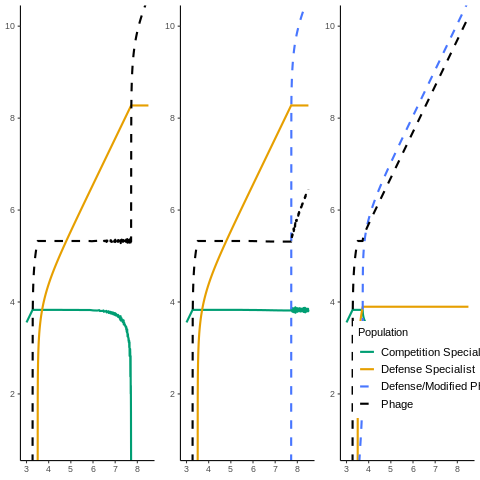

In [23]:
%%R -i dfgen,dfpar,dfmem
library("ggplot2")
library("gridExtra")

custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","Phage"="#000000",
                                                  "Competition Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1",
                                                 "Defense/Modified Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed",
                                                 "Competition Phage"="dashed","Defense Phage"="dashed",
                                                 "Defense/Modified Phage"="dashed"))


g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

sim_lim=200                      
ylowerlim = 10
yupperlim=10^10
lsize=1

plt_simpleVC<-function(df){
    
  plt<-ggplot(df,aes(x=Sr,y=value,color=Population))+
  geom_line(aes(linetype=Population),size=lsize)+custom_linetype+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
  custom_colorscale
    
  return(plt)
}

A<-plt_simpleVC(dfgen)
B<-plt_simpleVC(dfpar)
C<-plt_simpleVC(dfmem)

ggsave("figures/SimpleGeneral.png",plot=A,device="png",dpi=1200)
ggsave("figures/SimpleParallel.png",plot=B,device="png",dpi=1200)
ggsave("figures/SimpleMemory.png",plot=C,device="png",dpi=1200)
gridplt<-grid.arrange(A + guides(color=FALSE,linetype=FALSE)+theme(axis.title.x=element_blank(),
                                                                   axis.title.y=element_blank()), 
                      B + guides(color=FALSE,linetype=FALSE)+theme(axis.title.x=element_blank(),
                                                                   axis.title.y=element_blank()),
                      C + theme(legend.position = c(0.67, 0.20),legend.text=element_text(size=11.25),
                                axis.title.y=element_blank(),axis.title.x=element_blank()),#guides(color=FALSE,linetype=FALSE), 
                      nrow = 1)


<a id=par></a>

# Adding More Producers to our Models

Now that we have demonstrated the effects of the simplified system, now we can explore the effect of adding more hosts to the system. In the general model, we expect to have the sucession of increasing defensive types and extinction of competitive types as nutrients increase. In the parallel model, we expect to see competitve types enter first at low nutrients and coexsist with defensive types that enter at high nutrients, but have a higher overall abundance.

Note: the script src/partial_resistance.py was used to evaluate 

[Top of Page](#top)

In [5]:
orgRM=[]
rmcounter=0
for i in range(0,10):
    orgRM.append([])
    while i > len(orgRM[-1]):
        orgRM[-1].append(rmcounter)
        rmcounter+=1

t_final = 2000
steps = 500
Sr_rng = np.logspace(4.5,10,500)
alpha,phi,delta_p,delta_c,beta=1.0,1e-8,.2,.2,25.0

# GENERAL
print("Running General Model")
r,members,c=General_interaction(orgRM)
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,Producer_Consumer_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
df.to_csv("data/10member_General_endpoints.csv",index=False)


#Parallel
print("Running Parallel Model")
r,members,c=Parallel_interaction(orgRM)
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,Producer_Consumer_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
df.to_csv("data/10member_Parallel_endpoints.csv",index=False)


Running General Model
Preparing to run 500 simulations between 31622.776601683792 and 10000000000.0
100.00% Complete
Running Parallel Model
Preparing to run 500 simulations between 31622.776601683792 and 10000000000.0
100.00% Complete
Running Memory Model
Preparing to run 100 simulations between 31622.776601683792 and 316227766.01683795
100.00% Complete


In [9]:
def R_prep(df,extra=[]):
    dfR=get_ProducerColumns(df,extra)
    idvars=['Sr']+extra
    dfR = pd.melt(dfR,id_vars=idvars)
    dfR.columns = idvars+["NumRM","value"]
    dfR['NumRM'] = [ int(el.split('_')[-1]) for el in dfR['NumRM'] ]
    return(dfR)


def get_ProducerColumns(df,extra=[]):
    _=['Sr']+extra
    for member in list(df.columns):
        if 'P_' in member:
            _.append(member)
    df = df[_]
    return(df)

#This must be identical to partial_resistance.py
i_pr = {i:pr for i,pr in enumerate(np.around(np.arange(start=0.0,stop=1.05,step=.05),4))}
dfs=[]
path ='data/partial_r/orgRM_unique/'
for file in os.listdir(path):
    if '.csv' in file:
        df = pd.read_csv(path+file,index_col=False)
        i = int(file.split('_')[-1].split('.')[0])
        if i_pr[i] in [.9,.5,.1]:
            df['Model'] = "Memory, pr={}".format(str(i_pr[i]))
            dfs.append(df)
        if i_pr[i] == .9:
            df_=pd.read_csv(path+file,index_col=False)
            dfmem=R_prep(df_)
# Because final abundance of Memory ~= Parallel, we will consolidate
# to ploting only the general model instead of Parallel and General
df = pd.read_csv("data/10member_General_endpoints.csv",index_col=False)
df['Model'] = "General/Parallel"
dfs.append(df)

#df = pd.read_csv("data/10member_Parallel_endpoints.csv",index_col=False)
#df['Model'] = "Parallel"
#dfs.append(df)
        
df = pd.concat(dfs)

df = get_ProducerColumns(df,['Model'])
df['total_abundance'] = df[df.columns[2:]].sum(axis=1)
df['HighestRM'] = df[df.columns[2:-1]].idxmax(axis=1)
df['HighestRM'] = [int(el.split('_')[-1]) for el in df['HighestRM']]
df_totals = df[['Sr','Model','total_abundance','HighestRM']]

df=pd.read_csv("data/10member_Parallel_endpoints.csv")
dfpar=R_prep(df)
dfpar = dfpar[dfpar['NumRM'] <4]

df=pd.read_csv("data/10member_General_endpoints.csv")
dfgen=R_prep(df)
dfgen = dfgen[dfgen['NumRM'] <4]

/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


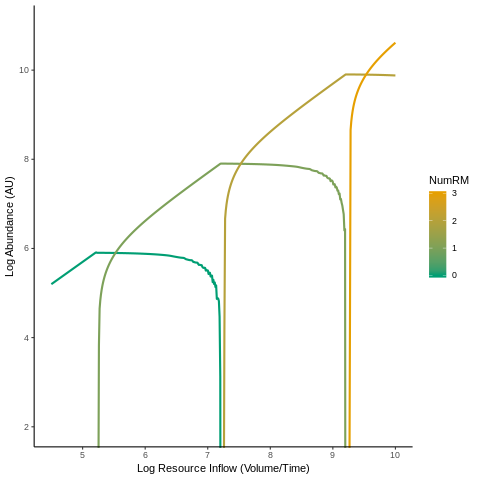

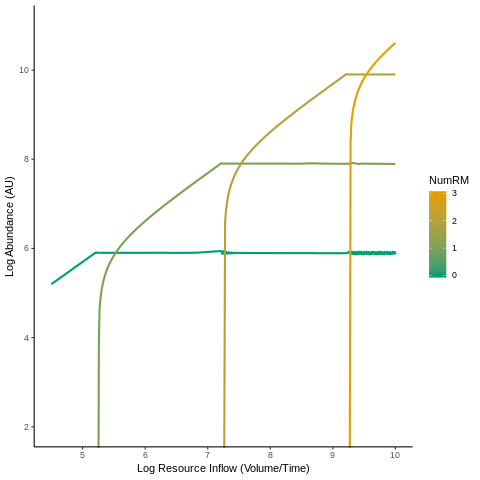

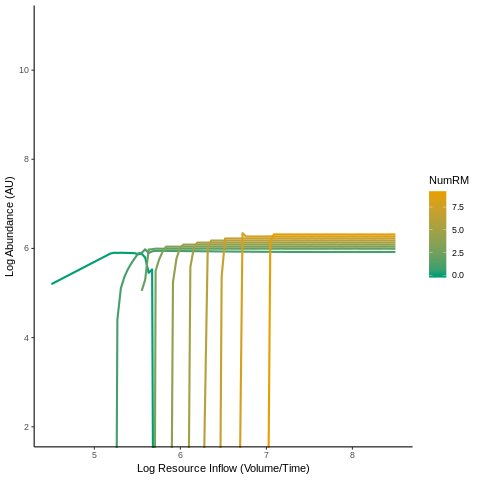

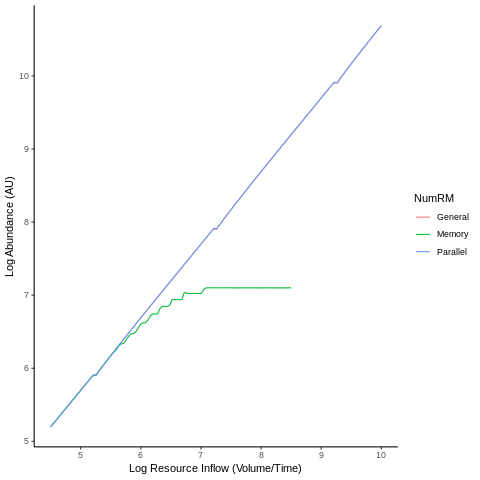

In [10]:
%%R -i dfgen,dfpar,dfmem,df_t
library("ggplot2")
library("gridExtra")


custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","Phage"="#000000",
                                                  "Competition Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1",
                                                 "Defense/Modified Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed",
                                                 "Competition Phage"="dashed","Defense Phage"="dashed",
                                                 "Defense/Modified Phage"="dashed"))



g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

sim_lim=200                      
ylowerlim = 10^2
yupperlim=10^11
lsize=1



plt_ComplexVC<-function(df){
    
  plt<-ggplot(df,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line(size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
    scale_colour_gradient(low = '#009E73',high = "#E69F00")
    
  return(plt)
}

A<-plt_ComplexVC(dfgen)
B<-plt_ComplexVC(dfpar)
C<-plt_ComplexVC(dfmem)
D<-ggplot(df_t,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line()+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))


ggsave("figures/ComplexGeneral.png",plot=A,device="png",dpi=1200)
ggsave("figures/ComplexParallel.png",plot=B,device="png",dpi=1200)
ggsave("figures/ComplexMemory.png",plot=C,device="png",dpi=1200)
ggsave("figures/ComplexAll.png",plot=D,device="png",dpi=1200)

#gridplt<-grid.arrange(A + guides(color=FALSE,linetype=FALSE)+theme(axis.title.x=element_blank(),
#                                                                   axis.title.y=element_blank()), 
#                      B + theme(legend.position = c(0.67, 0.20),legend.text=element_text(size=11.25),
#                                axis.title.y=element_blank(),axis.title.x=element_blank()),#guides(color=FALSE,linetype=FALSE), 
#                      nrow = 1)
print(A)
print(B)
print(C)
print(D)
#ggsave("figures/General_Multimember.png",plot=plt,device="png",dpi=1200)


<a id=mem></a>

# Memory - The amount of partial memory directly impacts demishing returns of population increases from RM

Our Memory model is special because the identity of the defense system is important to the overall competiton between simulation constituents

[Top of Page](#top)

# Identity test

In [164]:
orgRM=[]
rmcounter=0
for i in range(3,10):
    orgRM.append([])
    rmcounter=0
    while i > len(orgRM[-1]):
        orgRM[-1].append(rmcounter)
        rmcounter+=1

Sr_rng = np.logspace(4.5,10,500)
alpha,phi,delta_p,delta_c,beta=1.0,1e-8,.2,.2,25.0

#Memory Model- We are assuming imperfect in vivo methylation
t_final = 3000
steps = 2000
Sr_rng = np.logspace(4.5,8.5,100)
print("Running Memory Model")
r,members,c=Memory_interaction(orgRM,partial_resistance_function=lambda pr:(.9**pr))
initvalues=[('R',1)]
for member in members:
    initvalues.append(tuple([member,100]))
traits=load_traits(alpha,phi,delta_p,delta_c,beta,c,r)
dfs =Sr_sweep(Sr_rng,GenMem_ODE,initvalues,traits,t_final,steps,seed=True)
df = find_endpoints(dfs)
#df.to_csv("data/10member_Memory_endpoints.csv",index=False)
dfmem = R_prep(df)


Running Memory Model
Preparing to run 100 simulations between 31622.776601683792 and 316227766.01683795


/home/spiridon/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100.00% Complete


In [169]:
def isolate_df(dfs,i):
    df=dfs[i]
    _=['t']
    for member in list(df.columns):
        if 'P_' in member:
            _.append(member)
    df = df[_]
    df['sum']=df[_[1:]].sum(axis=1)
    df = pd.melt(df,id_vars='t')
    df.columns = ["t","NumRM","value"]
    df['NumRM'] = [ str(el.split('_')[-1]) for el in df['NumRM'] ]
    return(df)

In [176]:
df=isolate_df(dfs,33)
df1=isolate_df(dfs,34)
df2=isolate_df(dfs,50)

/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


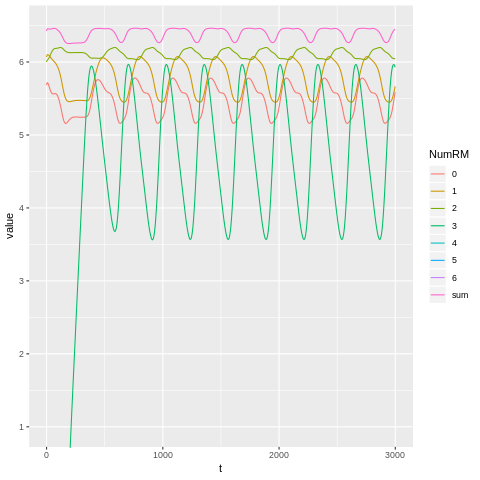

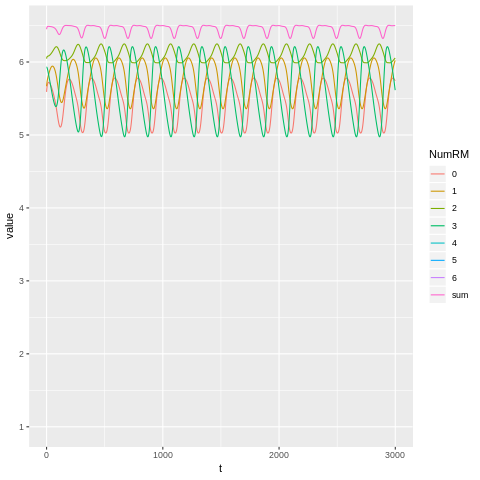

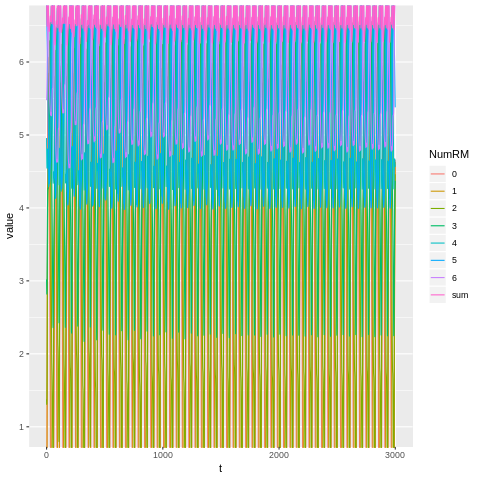

In [177]:
%%R -i df,df1,df2

ylowerlim = 10^1
yupperlim=10^6.5

plt<-function(dat){
    x<-ggplot(dat,aes(x=t,y=value,group=NumRM,color=NumRM))+
  geom_line()+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))  
    return(x)
}

a<-plt(df)

b<-plt(df1)

c<-plt(df2)

print(a)
print(b)
print(c)

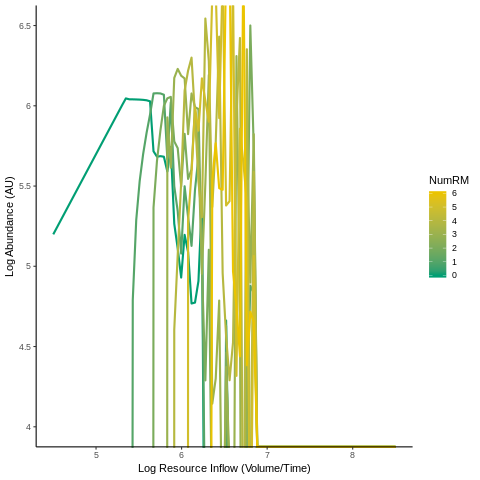

In [174]:
%%R -i dfmem

sim_lim=200                      
ylowerlim = 10^4
yupperlim=10^6.5
lsize=1



plt_ComplexVC<-function(df){
    
  plt<-ggplot(df,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line(size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
    scale_colour_gradient(low = '#009E73',high = "#ebc400")#"#E69F00")
    
  return(plt)
}

C<-plt_ComplexVC(dfmem)
print(C)

# Latin Hyper Cube
Latin hypercube sampling allows us to robustly expolre parameter space of all of our variables, allowing is to visuaize the given variance in the system. 

We will sample the following parameters  
$\beta$, $\phi$, $\alpha$, $c$, $r$, $\delta_{c}$ and $\delta_{p}$

[Top of Page](#top)

In [40]:
from pyDOE import lhs
from scipy.stats import uniform
def get_parameters(samples=100):
    LHC=lhs(8,samples=samples)
    x1,x2,x3,x4,x5,x6,x7,x8=LHC.T
    parameters = {'phi':np.power(10,-(uniform(5,3).ppf(x1))), #sampling log space
                  'delta_p':uniform(.15,.15).ppf(x2),
                  'delta_c':uniform(.15,.15).ppf(x3),
                  'beta':[int(el) for el in uniform(5,45).ppf(x4)],
                  'alpha':uniform(.75,.5).ppf(x5),
                  'c':uniform().ppf(x6), 
                  'r':np.power(10,-(uniform(1,4).ppf(x7))),
                  'pr':uniform().ppf(x8)
                 }#sampling log space
    df=pd.DataFrame(parameters)
    df=df[['alpha','beta','c','r','phi','delta_p','delta_c','pr']]
    return(df)


LHS_parameters = get_parameters(1000)           
LHS_parameters.to_csv('data/LHS_scheme.csv',index=False)

In [5]:
#### LHS_parameters = pd.read_csv('data/LHS_scheme.csv')
print("LHS stats")
LHS_parameters.describe()

LHS stats


,alpha,beta,c,r,phi,delta_p,delta_c,pr
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,0.999998,27.003000,0.499984,0.010855,1.446256e-06,0.225000,0.224999,0.499991
std,0.144406,12.992683,0.288801,0.020620,2.270154e-06,0.043323,0.043322,0.288830
min,0.750373,5.000000,0.000005,0.000010,1.002483e-08,0.150046,0.150032,0.000408
25%,0.875011,16.000000,0.250096,0.000100,5.638812e-08,0.187576,0.187476,0.250015
50%,1.000117,27.000000,0.500197,0.000999,3.161377e-07,0.225009,0.224958,0.499677
75%,1.124962,38.000000,0.749915,0.009991,1.775157e-06,0.262456,0.262422,0.750131
max,1.249858,49.000000,0.999092,0.099111,9.976612e-06,0.299981,0.299863,0.999193


In [ ]:
#### def prep_LHS(LHSfile,datadir,file_ident):
    LHS = pd.read_csv(LHSfile)
    LHScols = list(LHS.columns)
    i_LHS =  {i:row for i,row in LHS.iterrows()}
    df_columns = ['R','Competition Specialist','Defense Specialist','Sr','rep']+LHScols
    dfs=[]
    for file in os.listdir(datadir):
        if file_ident in file:
            print("Processing "+file,end='\r')
            i = int(file.split('_')[-1].split('.')[0])
            df = pd.read_csv(datadir+file,index_col=False)
            df = df[['R','P_0','P_1','Sr']]
            df['rep'] = i
            for LHSparam in LHScols:
                df[LHSparam] = i_LHS[i][LHSparam]
            df.columns= df_columns
            dfs.append(df)
    print(" ",end='\r')
    print("Processing Complete")
    df = pd.concat(dfs)
    df = df[df['r']< 1-df['c']]
    return(df)
    
LHSfile = 'data/LHS_scheme.csv'
results=prep_LHS(LHSfile, 'data/LHS/LHS_results/', 'Gen')
results.to_csv('data/LHS/general.csv',index=False)

results=prep_LHS(LHSfile, 'data/LHS/LHS_results/', 'Par')
results.to_csv('data/LHS/Parallel.csv',index=False)

results=prep_LHS(LHSfile, 'data/LHS/LHS_results/', 'Mem')
results.to_csv('data/LHS/Memory.csv',index=False)

In [112]:
def process_LHS(results):
    #We must provide a floor for our data to .1 so we can visualize in logspace.
    #our floor will be 1 (not inclusive) and we will fix these datapoints at an abundance of .1
    Dtemp=[]
    Ctemp=[]
    parameters = list(results.columns)[5:]
    results['Sr']=results['Sr'].round()
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['Defense Specialist']=Dtemp
    results['Competition Specialist']=Ctemp
    S_rng = set(results['Sr'])
    m=[]
    qh=.75
    ql=.25
    for S in S_rng:
        df = results[results['Sr'] == S][['Competition Specialist','Defense Specialist']]
        rep_num=len(df)
        t=list(pd.concat([df.mean(),df.median(),df.std(),df.quantile(qh),df.quantile(ql)]))
        t.append(rep_num)
        t.append(S)
        m.append(t)
    df = pd.DataFrame(m)
    #building column names for stats of each treatment
    stats=['mean','median','std','qh','ql','rep_num',"Sr"]
    col=[]
    for stat in stats[:-2]:
        col.append('C'+stat)
        col.append('D'+stat)
    col.extend(stats[-2:])
    df.columns=col
    results['ratio'] = results['Defense Specialist']/results['Competition Specialist']
    ratio = results[['Sr','rep','ratio']+parameters]

    #Here, we are sampling points in logspace so we can make bins
    bins = np.logspace(np.log10(ratio['Sr'].min()),np.log10(ratio['Sr'].max()),50)
    #finding the interval each S belongs to
    ratio['bin'] = pd.cut(ratio['Sr'], bins)
    #Describing the bin as the midpoint of the interval for ploting
    ratio = ratio.dropna()
    ratio['bin_Sr'] = [intS.mid for intS in ratio['bin']]
    ratio= ratio[['Sr','ratio','bin_Sr','rep']+parameters]
    return(df,ratio)

gen=pd.read_csv('data/LHS/general.csv')
df_gen,ratio_gen = process_LHS(gen)

par=pd.read_csv('data/LHS/Parallel.csv')
df_par,ratio_par = process_LHS(par)

mem=pd.read_csv('data/LHS/Memory.csv')
df_mem,ratio_mem = process_LHS(mem)

/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

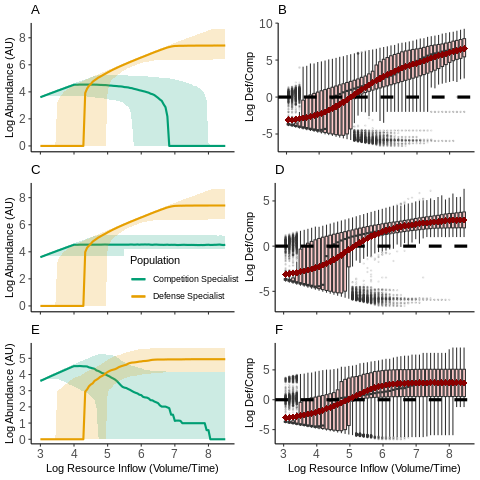

In [113]:
%%R -i df_gen,ratio_gen,df_par,ratio_par,df_mem,ratio_mem
library("ggplot2")
library("gridExtra")


custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","General Phage"="#000000","Competition Phage"="#000000",
                                                  "Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed"))


g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1


ModVar<-function(df){ggplot(df,aes(x=Sr,y=Cmedian))+
  geom_ribbon(aes(ymin = Cql, ymax = Cqh),alpha=.2, fill = "#009E73")+
  geom_line(aes(color="c"),alpha=1,size=lsize)+
  geom_ribbon(aes(ymin = Dql, ymax = Dqh),alpha=.2, fill = "#E69F00")+
  geom_line(aes(y=Dmedian,color="d"),alpha=1,size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_colour_manual(guide = 'legend',name = 'Population', 
         values=c('c'='#009E73','d'='#E69F00'), 
         labels = c('Competition Specialist','Defense Specialist'))#+
  #coord_cartesian(ylim=c(ylowerlim,yupperlim))
}
      
      
RatVar<-function(ratio){ggplot(ratio, aes(x=bin_Sr, y=ratio,group=bin_Sr))+
  geom_boxplot(notch=FALSE, fill="red",outlier.size=.5,
               outlier.alpha=.1, alpha=0.2)+#,outlier.shape=NA,)+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  geom_hline(yintercept=1, size=1.5,linetype="dashed", color = "black")+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Def/Comp")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size))+
    stat_summary(fun.y=mean, colour="darkred", geom="point", 
               shape=18, size=3,show_guide = FALSE)
                       }


A<-ModVar(df_gen)+guides(color=FALSE)+labs(title="A")+
    theme(axis.title.x=element_blank(),axis.text.x=element_blank())
B<-RatVar(ratio_gen)+guides(color=FALSE)+labs(title="B")+
    theme(axis.title.x=element_blank(),axis.text.x=element_blank())
C<-ModVar(df_par)+labs(title="C")+
    theme(axis.title.x=element_blank(),axis.text.x=element_blank(),
         legend.position = c(0.75, 0.25))
D<-RatVar(ratio_par)+guides(color=FALSE)+labs(title="D")+
    theme(axis.title.x=element_blank(),axis.text.x=element_blank())
E<-ModVar(df_mem)+guides(color=FALSE)+labs(title="E")
F<-RatVar(ratio_mem)+labs(title="F") 
gridplt<-grid.arrange(A,B,
                      C,D,
                      E,F,
                      nrow = 3)

ggsave("figures/Model_Variance.png",plot=gridplt,width=7.5,height=10,device="png",dpi=1200)


# Cost of Reistance

In [134]:
def prep_COR(datadir,file_ident,i_r,i_c):
    
    dfs=[]
    for file in os.listdir(datadir):
        if file_ident in file:
            print("Processing "+file,end='\r')
            i = int(file.strip('.csv').split('_')[2])
            df = pd.read_csv(datadir+file,index_col=False)
            df = df[['R','P_0','P_1','Sr']]
            df['rep'] = i
            df.columns= ['R','Competition Specialist','Defense Specialist','Sr','rep']
            df['r'] = i_r[i]
            df['c'] = i_c[i]
            dfs.append(df)
    print(" ",end='\r')
    print("Processing Complete")
    return(pd.concat(dfs))
#this is from COR.py
alpha,phi,delta_p,delta_c,beta=1.0,1e-8,.2,.2,25.0
m=[]
for r in [.001,.01,.5]:
    for c in np.linspace(0.01,.99,99):
        m.append([alpha,phi,delta_p,delta_c,beta,c,r])
parameters = pd.DataFrame(m)
parameters.columns = ['alpha','phi','delta_p','delta_c','beta','c','r']
i_r = {i:row['r'] for i,row in parameters.iterrows()}
i_c = {i:row['c'] for i,row in parameters.iterrows()}

Sr_lower=10**(4.9)

results=prep_COR('data/COR/COR_results/','Gen',i_r,i_c)
results = results[results['Sr'] >=Sr_lower]
results.to_csv('data/COR/general.csv',index=False)

results=prep_COR('data/COR/COR_results/','Par',i_r,i_c)
results = results[results['Sr'] >=Sr_lower]
results.to_csv('data/COR/Parallel.csv',index=False)

results=prep_COR('data/COR/COR_results/','Mem',i_r,i_c)
results = results[results['Sr'] >=Sr_lower]
results.to_csv('data/COR/Memory.csv',index=False)

Processing Complete272.csv
Processing Complete74.csvv
Processing Complete45.csvv


In [131]:
def COR_df(results):
    Dtemp=[]
    Ctemp=[]
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['D']=Dtemp
    results['C']=Ctemp
    results['ratio'] = results['D'] / results['C']

    results = results[results['D'] > 1]
    r_df={}
    for r in set(results['r']):
        dat = {'r':[], 'Sr':[], 'd_enter':[], 'd_only':[], 'eql':[]}
        df =results[results['r']== r]
        for Sr in np.sort(np.array(list(set(df['Sr']))),axis=None):
            df_Sr = df[df['Sr']==Sr]

            #d_enter
            d_enter = float(df_Sr['c'].max())

            #removing points where C does not exsist
            df_Sr_C = df_Sr[df_Sr['C'] > 1]

            #d_only
            d_only = float(df_Sr_C['c'].min())

            #df_eql
            #Because dc/dSr is always positive, we will remove
            #datapoints below c from last df_eql to avoid
            #artificats in plots at high nutrients 
            #(where true c is at d_only, but varation in the ratio
            #causes it to be toward the x-axis)
            if dat['eql']:
                #After costs are >.1, use the derivative to determine window size for change
                #
                if dat['eql'][-1] >.25:
                    dc = abs(dat['eql'][-1] - dat['eql'][-2])
                    df_Sr_C = df_Sr_C[df_Sr_C['c'] >= dat['eql'][-1]-dc]
            t = df_Sr_C.iloc[(df_Sr_C['ratio']-1).abs().argsort()[:2]]
            if len(t['c']) == 2:
                #midpoint
                c1,c2 = list(t['c'])
                df_eql = (c1+c2)/2
            elif len(t['c']) == 1:
                df_eql = float(t['c'])

            dat['r'].append(r)
            dat['Sr'].append(Sr)
            dat['eql'].append(df_eql)
            dat['d_enter'].append(d_enter)
            dat['d_only'].append(d_only)
        df = pd.DataFrame(dat)
        Sr_C_extinct = df[df['d_only'] == df['d_only'].min()]['Sr'].max()
        d_only_temp = []
        for index,row in df.iterrows():
            if row['Sr']< Sr_C_extinct:
                d_only_temp.append(np.nan)
            elif pd.isnull(row['d_only']):
                d_only_temp.append(float(row['d_enter']))
            else:
                d_only_temp.append(float(row['d_only']))
        df['d_only'] =d_only_temp
        r_df[r] = df
    return(r_df)
gen= COR_df(pd.read_csv("data/COR/general.csv"))
par= COR_df(pd.read_csv("data/COR/Parallel.csv"))
mem= COR_df(pd.read_csv("data/COR/Memory.csv"))


gen_001 = gen[.001]
gen_01 = gen[.01]
gen_5 = gen[.5]

par_001 = par[.001]
par_01 = par[.01]
par_5 = par[.5]

mem_001 = mem[.001]
mem_01 = mem[.01]
mem_5 = mem[.5]


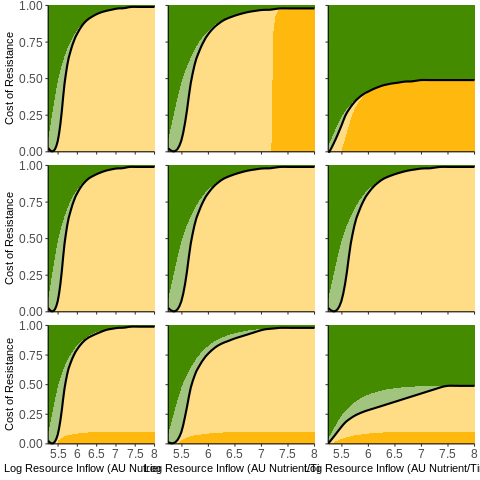

In [137]:
%%R -i gen_001,gen_01,gen_5,par_001,par_01,par_5,mem_001,mem_01,mem_5
library("ggplot2")
library("gridExtra")

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1

COR<-function(df){
    predict_span=.2
    df$eql.pred<-predict(loess(eql ~ Sr,data=df,span=predict_span))
    df$d_enter.pred<-predict(loess(d_enter ~ Sr,data=df,span=predict_span))
    
     if (tail(df$d_only,n=1) != 0.01){
     df$d_only.pred<-predict(loess(d_only ~ Sr,data=df,
                              span=predict_span,na.action = na.exclude))
     gplt<-ggplot(df,aes(y=eql.pred,x=Sr))+
             geom_ribbon(data=df,aes(ymin = 0, ymax = d_only.pred),
                       fill='darkgoldenrod1')
     }else{
         gplt<-ggplot(df,aes(y=eql.pred,x=Sr))
     }
    gplt<-gplt+
      geom_ribbon(aes(ymin = 0, ymax = eql.pred),
                fill='darkgoldenrod1',alpha = 0.5)+
      #geom_ribbon(aes(ymin = 0, ymax = d_only.pred),
      #          fill='darkgoldenrod1')+
      geom_ribbon(aes(ymax = 1, ymin = d_enter.pred),
                fill='chartreuse4')+
      geom_ribbon(aes(ymax = 1, ymin = eql.pred),
                fill='chartreuse4',alpha = 0.5)+
      geom_line(size=1)+
    
      scale_x_log10(
          breaks = scales::trans_breaks("log10", function(x) {10^x}),
          labels = scales::trans_format("log10", scales::math_format(.x)),
          expand=c(0,0))+
      theme_bw()+
      theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
           axis.text=element_text(size=axis_text_size))+
      labs(x="Log Resource Inflow (AU Nutrient/Time)",y="Cost of Resistance")+
    #coord_cartesian(ylim=c(0,1),xlim=c(10^4.5,10^7
      scale_y_continuous(expand = c(0, 0)) +
      coord_cartesian(ylim=c(0,1))

    return(gplt)
}
A<-COR(gen_001)+theme(axis.title.x=element_blank(),,axis.text.x=element_blank())
B<-COR(gen_01)+theme(axis.title=element_blank(),axis.text=element_blank())
C<-COR(gen_5)+theme(axis.title=element_blank(),axis.text=element_blank())
D<-COR(par_001)+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
E<-COR(par_01)+theme(axis.title=element_blank(),axis.text=element_blank())
F<-COR(par_5)+theme(axis.title=element_blank(),axis.text=element_blank())
G<-COR(mem_001)#+theme(axis.title.x=element_blank(),axis.title.y=element_blank())
H<-COR(mem_01)+theme(axis.title.y=element_blank(),axis.text.y=element_blank())
I<-COR(mem_5)+theme(axis.title.y=element_blank(),axis.text.y=element_blank())

gridplt<-grid.arrange(A,B,C,
                      D,E,F,
                      G,H,I,
                      nrow = 3)

In [140]:

parameters = pd.read_csv('data/pr_r_parameters.csv',index_col=0)
parameters.columns=['alpha','phi','delta_p','delta_c','beta','c','r','pr']
i_r = {i:row['r'] for i,row in parameters.iterrows()}
i_c = {i:row['c'] for i,row in parameters.iterrows()}


for pr in ['pr9','pr5','pr1']:
    results=prep_COR('data/pr_r/pr_r_results/',pr,i_r,i_c)
    results = results[results['Sr'] >=Sr_lower]
    results.to_csv('data/pr_r/MEM{}.csv'.format(pr),index=False)



pr9=pd.read_csv("data/pr_r/MEMpr9.csv")
pr5=pd.read_csv("data/pr_r/MEMpr5.csv")
pr1=pd.read_csv("data/pr_r/MEMpr1.csv")


r_pr9= COR_df(pr9)
r_pr5= COR_df(pr5)
r_pr1= COR_df(pr1)


pr9_001 = r_pr9[.001]
pr9_01 = r_pr9[.01]
pr9_5 = r_pr9[.5]

pr5_001 = r_pr5[.001]
pr5_01 = r_pr5[.01]
pr5_5 = r_pr5[.5]

pr1_001 = r_pr1[.001]
pr1_01 = r_pr1[.01]
pr1_5 = r_pr1[.5]


Processing Complete98_pr9.csvv
Processing Complete472_pr5.csv
Processing Complete621_pr1.csv


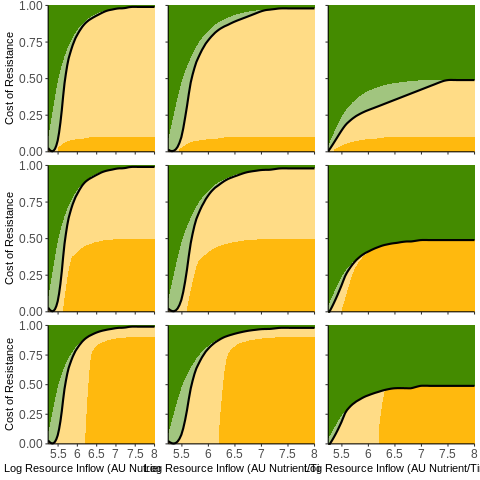

In [138]:
%%R -i pr9_001,pr9_01,pr9_5,pr5_001,pr5_01,pr5_5,pr1_001,pr1_01,pr1_5
library("ggplot2")
library("gridExtra")

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1
A<-COR(pr9_001)+theme(axis.title.x=element_blank(),,axis.text.x=element_blank())
B<-COR(pr9_01)+theme(axis.title=element_blank(),axis.text=element_blank())
C<-COR(pr9_5)+theme(axis.title=element_blank(),axis.text=element_blank())
D<-COR(pr5_001)+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
E<-COR(pr5_01)+theme(axis.title=element_blank(),axis.text=element_blank())
F<-COR(pr5_5)+theme(axis.title=element_blank(),axis.text=element_blank())
G<-COR(pr1_001)#+theme(axis.title.x=element_blank(),axis.title.y=element_blank())
H<-COR(pr1_01)+theme(axis.title.y=element_blank(),axis.text.y=element_blank())
I<-COR(pr1_5)+theme(axis.title.y=element_blank(),axis.text.y=element_blank())

gridplt<-grid.arrange(A,B,C,
                      D,E,F,
                      G,H,I,
                      nrow = 3)

In [160]:
pr9['pr'] = .9
pr5['pr'] = .5
pr1['pr'] = .1
pr = pd.concat([pr9,pr5,pr1]) 
pr=pr[pr['Sr'] > 10**7.5]
DS = []
for el in pr['Defense Specialist']:
    if el <1:
        DS.append(1)
    else:
        DS.append(el)
pr['Defense Specialist'] = DS

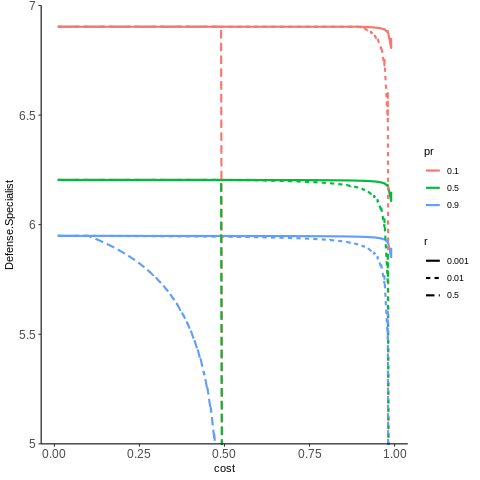

In [174]:
%%R -i pr
pr$r<-as.factor(pr$r)
pr$pr<-as.factor(pr$pr)
ggplot(pr,aes(y=Defense.Specialist,x=c,linetype=r,color=pr))+
geom_line(size=1)+  
      scale_y_log10(
          breaks = scales::trans_breaks("log10", function(x) {10^x}),
          labels = scales::trans_format("log10", scales::math_format(.x)),
          expand=c(0,0))+
      theme_bw()+
      theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
           axis.text=element_text(size=axis_text_size))+
      labs(x="cost",y="Defense.Specialist")+
     coord_cartesian(ylim=c(1e5,1e7))
